In [1]:
from dask.distributed import Client, LocalCluster
# from dask_jobqueue import SLURMCluster

cluster = LocalCluster()
# cluster = SLURMCluster(cores=12, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='118GB', interface='ib0'
#                       ) 
cluster.scale(12)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/condapack/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45133 Dashboard: http://127.0.0.1:46065/status,Cluster Workers: 12 Cores: 84 Memory: 405.28 GB


In [2]:
!squeue -u tuchida

import time
nb_workers = 0
while True:
    nb_workers = len(client.scheduler_info()["workers"])
    if nb_workers >= 10:
        break
    time.sleep(1)
print(nb_workers)

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          10436359      visu      viz  tuchida  R    1:02:11      1 n4368
12


In [3]:
import xarray as xr
import numpy as np
import xscale
import gsw
import os.path as op
from xhistogram.xarray import histogram as xhist

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
ddir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
xtra = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02X-S'
scratch = '/scratch/cnt0024/hmg2840/tuchida/temp'

In [5]:
g = 9.81
Ce = 0.01
rho0 = 999.8
ys,ye = (2000,2500)
xs,xe = (2300,3100)
ncoars = 15
zchunk = 15

dsmask = xr.open_dataset(op.join(ddir,'../eNATL60-I/mesh_mask_eNATL60_3.6.nc'), chunks={'z':zchunk})
dsmask

<xarray.Dataset>
Dimensions:       (t: 1, x: 8354, y: 4729, z: 300)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lev       (z) float32 dask.array<chunksize=(15,), meta=np.ndarray>
    time_counter  (t) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 4729, 8354), meta=np.ndarray>
    e3t_0         (t, z, y, x) float64 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    e3u_0         (t, z, y, x) float64 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    e3v_0         (t, z, y, x) float64 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 15, 4729, 8354), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 15), meta=np.ndarray>
    gdepw_1d      (t, z) float64 dask.array<chunksize=(1, 15), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 15),

In [6]:
At = (dsmask.e1t * dsmask.e2t)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
Au = (dsmask.e1u * dsmask.e2u)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
Av = (dsmask.e1v * dsmask.e2v)[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1u = dsmask.e1u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e2u = dsmask.e2u[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e1v = dsmask.e1v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
# e2v = dsmask.e2v[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e2t = dsmask.e2t[0].sel(y=slice(ys,ye),x=slice(xs,xe))
e1t = dsmask.e1t[0].sel(y=slice(ys,ye),x=slice(xs,xe))
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))
# e3t = dsmask.e3t_1d[0]
# e3w = dsmask.e3w_1d[0]

In [6]:
# cori = gsw.f(dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe)))
# fb = xr.apply_ufunc(gsw.f,(dsmask.nav_lat.sel(y=slice(ys,ye),x=slice(xs,xe))*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
#                            / At.coarsen({'y':5,'x':5}, boundary='trim').sum(),
#                     dask='parallelized', output_dtypes=[float,]
#                    )
# e1tb = e1t.coarsen({'y':5,'x':5},boundary='trim').sum()
# e2tb = e2t.coarsen({'y':5,'x':5},boundary='trim').sum()
# Aub = Au.coarsen({'y':5,'x':5}, boundary='trim').sum()
# Avb = Av.coarsen({'y':5,'x':5}, boundary='trim').sum()
# Atb = At.coarsen({'y':5,'x':5}, boundary='trim').sum()

In [7]:
def filt(da, area=None):
    
    if area is not None:
        win_2D = (da * area).window
    else:
        win_2D = da.window
    
    win_2D.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
    bw = win_2D.boundary_weights(drop_dims=[])
    da_LS = win_2D.convolve(weights=bw)
    
    if area is not None:
        area_win = area.window
        area_win.set(window='hanning', cutoff=20, dim=['y','x'], n=[30,30])
        bw = area_win.boundary_weights(drop_dims=[])
        da_LS *= area_win.convolve(weights=bw)**-1
    
    da_SS = da - da_LS
    
    return da_SS

In [8]:
xr.open_dataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridW_20091102-20091102.nc'),
               chunks=({'time_counter':1,'depthw':1})).sel(depthw=slice(None,510)).vovecrtz[0,0].data.nbytes*1e-6

158.024264

In [8]:
dsW = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridW_200911*.nc'),
                        chunks={'time_counter':1,'depthw':1}, combine='by_coords'
                       ).sel(depthw=slice(None,510))
dsT = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridT_200911*.nc'),
                        chunks={'time_counter':1,'deptht':1}, combine='by_coords'
                       ).sel(deptht=slice(None,510))
dsS = xr.open_mfdataset(op.join(ddir,'00658801-00669600/eNATL60-BLBT02_1h_20091102_20091106_gridS_200911*.nc'),
                        chunks={'time_counter':1,'deptht':1}, combine='by_coords'
                       ).sel(deptht=slice(None,510))
dsW

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, depthw: 74, time_counter: 120, x: 8354, y: 4729)
Coordinates:
    nav_lon               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
    nav_lat               (y, x) float32 dask.array<chunksize=(4729, 8354), meta=np.ndarray>
  * depthw                (depthw) float32 0.0 1.0000261 ... 487.90018 500.50638
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2009-11-02T00:30:00 ... 2009-11-06T23:30:00
Dimensions without coordinates: axis_nbounds, x, y
Data variables:
    depthw_bounds         (time_counter, depthw, axis_nbounds) float32 dask.array<chunksize=(24, 1, 2), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    vovecrtz              (time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 1, 4729, 8354), meta=np.ndarray>
Attributes:
    name:         /scratch/tmp/5091688/eNATL60-BLBT02_1h_20091102_20091106_gridW
    description:  ocean W grid variables
    title:        ocean W grid variables
    Conventions:  CF-1.6
    timeStamp:    2019-Mar-09 11:57:06 GMT
    uuid:         b541dd09-f592-4c7f-a4fa-0e01f9b6bcfa
    ibegin:       0
    ni:           8354
    jbegin:       0
    nj:           10
    file_name:    eNATL60-BLBT02_1h_20091102_20091106_gridW_20091102-20091102.nc
    TimeStamp:    10/03/2019 00:59:17 +0100

In [10]:
maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)).isel(z=slice(None,len(dsW.depthw)))
    
CT = dsT.votemper.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']).chunk({'deptht':1})!=0.
                            )
SA = dsS.vosaline.sel(y=slice(ys,ye),x=slice(xs,xe)
                     ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']).chunk({'deptht':1})!=0.
                            )
w = dsW.vovecrtz.sel(y=slice(ys,ye),x=slice(xs,xe)
                    ).where(xr.DataArray(maskT.data, dims=['depthw','y','x']).chunk({'deptht':1})!=0.
                           )

buoy = -g*xr.apply_ufunc(gsw.sigma0, SA, CT, 
                         dask='parallelized', output_dtypes=[float,]
                        )*1e-3

ws = filt(w.chunk({'depthw':1}), area=At)
bs = filt(buoy.chunk({'deptht':1}), area=At)

wsbs = (ws.isel(depthw=slice(1,None)) 
        * bs.chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                                         method='linear').data
       )
wsbs

<xarray.DataArray (time_counter: 120, depthw: 73, y: 500, x: 800)>
dask.array<mul, shape=(120, 73, 500, 800), dtype=float64, chunksize=(1, 1, 500, 800), chunktype=numpy.ndarray>
Coordinates:
  * depthw         (depthw) float64 1.0 2.157 3.471 4.943 ... 475.4 487.9 500.5
    nav_lat        (y, x) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(500, 800), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 2009-11-02T00:30:00 ... 2009-11-06T23:30:00
Dimensions without coordinates: y, x

In [ ]:
wsbs[:,15].mean('time_counter').plot(figsize=(12,7), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')

In [ ]:
wsbs_b = ((wsbs*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
          * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
         )
s_b = ((SA*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )
t_b = ((CT*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
       / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
      )

z10 = 6
sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                        dask='parallelized', output_dtypes=[float,]
                       ).persist()
b_b = -g*sig0_b*1e-3

nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                       - sig0_b.isel(deptht=z10)
                      ) - 0.03).argmin(dim='deptht')

In [ ]:
import dask.array as dsar
xr.concat([xr.DataArray(np.random.random((2,4)), dims=['time','x']).chunk({'time':1}),
           xr.DataArray(np.random.random((3,4)), dims=['time','x']).chunk({'time':1})], 'time')

In [10]:
# dirs = np.arange(669601,756000,43200,dtype=int)
days = np.concatenate((np.arange(27,31,dtype=int), np.arange(1,17,dtype=int))).reshape((4,5))
# days = np.arange(17,32, dtype=int).reshape((3,5))
dirs = np.repeat(np.array([712801]),days.shape[0]+1)
print(days,dirs)

[[27 28 29 30  1]
 [ 2  3  4  5  6]
 [ 7  8  9 10 11]
 [12 13 14 15 16]] [712801 712801 712801 712801 712801]


In [11]:
month = 11
year = 2009

for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month+1
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
        dsW = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridW_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'depthw':zchunk}
                             ).sel(depthw=slice(None,810))
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        d2D = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                             )

        if i == days[0,0]:
            maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                                        ).isel(z=slice(None,len(dsW.depthw)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        w = dsW.vovecrtz[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                ).where(xr.DataArray(maskT.data, dims=['depthw','y','x']
                                                    ) != 0.)
        ssh = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                      ) != 0.)
    #     del dsT, dsS, dsW

        buoy = -g*(xr.apply_ufunc(gsw.sigma0, SA, CT, 
                                  dask='parallelized', output_dtypes=[float,]
                                 ) + 1e3 - rho0)*rho0**-1

        ws = filt(w, area=At).chunk({'depthw':zchunk})
        bs = filt(buoy, area=At).chunk({'deptht':-1})
        ts = filt(CT, area=At).chunk({'deptht':-1})
        ss = filt(SA, area=At).chunk({'deptht':-1})

        wsbs = (ws.isel(depthw=slice(1,None)) 
                * bs.interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                            method='linear').data
               )
        wsts = (ws.isel(depthw=slice(1,None)) 
                * ts.interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                            method='linear').data
               )
        wsss = (ws.isel(depthw=slice(1,None)) 
                * ss.interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                            method='linear').data
               )

        wsbs_b = ((wsbs*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                  * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                 )
        wsts_b = ((wsts*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                  * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                 )
        wsss_b = ((wsss*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                  * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                 )

        del ws, bs, ts, ss

#######################
        s_b = ((SA*At).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
               / At.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
              )
        t_b = ((CT*At).coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
               / At.coarsen({'y':ncoars,'x':ncoars}, boundary='trim').sum(skipna=True)
              )
    #     del SA, CT

        z10 = 6
        sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                                dask='parallelized', output_dtypes=[float,]
                               )
#         b_b = -g*sig0_b*1e-3

        nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                               - sig0_b.isel(deptht=z10)
                              ) - 0.03).argmin(dim='deptht')
        e3w = dsmask.e3w_0[0].sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3t = dsmask.e3t_0[0].sel(y=slice(ys,ye),x=slice(xs,xe)) * (1+ssh*gdepw**-1)
        e3w_b = ((e3w*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                 * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                )
        e3t_b = ((e3t*At).coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True) 
                 * At.coarsen({'y':ncoars,'x':ncoars},boundary='trim').sum(skipna=True)**-1
                )
#         MLD = (xr.ones_like(sig0_b) * sig0_b.deptht
#               )[{'deptht':nMLD_b.compute()}].compute()
        MLD = e3t_b.where(e3t_b.z<=nMLD_b.compute()).sum('z').compute()
        del nMLD_b, sig0_b
        if i == days[0,0]:
            MLD_b = MLD
        else:
            MLD_b = xr.concat([MLD_b, MLD], 'time_counter')
#         MLD = xr.open_dataset(op.join(scratch,
#                                       'GulfStream/wsbsb-bar_ML-24h_2010-01-01_01-25.nc')
#                              ).MLD


        wsbs_b = wsbs_b.where(wsbs_b.depthw <= MLD)
        wsts_b = wsts_b.where(wsts_b.depthw <= MLD)
        wsss_b = wsss_b.where(wsss_b.depthw <= MLD)
        
#####################  
        if i == days[0,0]:
            wsbsb_bar = ((wsbs_b
                          * xr.DataArray(e3w_b[1:len(wsbs_b.depthw)+1], 
                                         dims=['depthw','y','x'],
                                         coords={'depthw':wsbs_b.depthw.data}
                                        )
                         ).sum('depthw') * MLD**-1
                        ).compute()
            wstsb_bar = ((wsts_b
                          * xr.DataArray(e3w_b[1:len(wsts_b.depthw)+1], 
                                         dims=['depthw','y','x'],
                                         coords={'depthw':wsts_b.depthw.data}
                                        )
                         ).sum('depthw') * MLD**-1
                        ).compute()
            wsssb_bar = ((wsss_b
                          * xr.DataArray(e3w_b[1:len(wsss_b.depthw)+1], 
                                         dims=['depthw','y','x'],
                                         coords={'depthw':wsss_b.depthw.data}
                                        )
                         ).sum('depthw') * MLD**-1
                        ).compute()
        else:
            wsbsb_bar = xr.concat([wsbsb_bar, ((wsbs_b
                                                * xr.DataArray(e3w_b[1:len(wsbs_b.depthw)+1], 
                                                               dims=['depthw','y','x'],
                                                               coords={'depthw':wsbs_b.depthw.data}
                                                              )
                                               ).sum('depthw') * MLD**-1
                                              ).compute()
                                  ],
                                 'time_counter')
            wstsb_bar = xr.concat([wstsb_bar, ((wsts_b
                                                * xr.DataArray(e3w_b[1:len(wsts_b.depthw)+1], 
                                                               dims=['depthw','y','x'],
                                                               coords={'depthw':wsts_b.depthw.data}
                                                              )
                                               ).sum('depthw') * MLD**-1
                                              ).compute()
                                  ],
                                 'time_counter')
            wsssb_bar = xr.concat([wsssb_bar, ((wsss_b
                                                * xr.DataArray(e3w_b[1:len(wsss_b.depthw)+1], 
                                                               dims=['depthw','y','x'],
                                                               coords={'depthw':wsss_b.depthw.data}
                                                              )
                                               ).sum('depthw') * MLD**-1
                                              ).compute()
                                  ],
                                 'time_counter')

        del MLD, wsbs_b, wsts_b, wsss_b
        print(str(l)+'-'+str(i))
        
#         client.restart()
    
dsave = wsbsb_bar.to_dataset(name='wb')
dsave['wt'] = wstsb_bar
dsave['ws'] = wsssb_bar
dsave['MLD'] = MLD_b
dsave.to_netcdf(op.join(scratch,'GulfStream/wsbsb-bar_ML-24h_Ncoars%02d_%4d-%02d-%02d_%02d-%02d.nc' 
                        % (ncoars,year,j,days[0,0],m,days[-1,-1])))
#     BFK_bar.to_netcdf(op.join(scratch,'BFK_bar_2009-%2d-%02d_%2d-%02d.nc' % (j,days[k,0],l,days[k,-1])))
    
#     if k < len(dirs)-2:
#         del wsbsb_bar

11-27
11-28
11-29
11-30
12-1
12-2
12-3
12-4
12-5
12-6
12-7
12-8
12-9
12-10
12-11
12-12
12-13
12-14
12-15
12-16


In [9]:
month = 1
year = 2010
gdepw = xr.open_dataset(op.join(scratch,'gdepw_eNATL60.nc')
                       ).gdepw.sel(y=slice(ys,ye),x=slice(xs,xe))

for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
        dsW = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridW_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'depthw':zchunk}
                             ).sel(depthw=slice(None,810))
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'deptht':zchunk}
                             ).sel(deptht=slice(None,810))
        d2D = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT-2D_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                             )

        if i == days[0,0]:
            maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                                        ).isel(z=slice(None,len(dsW.depthw)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        w = dsW.vovecrtz[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                ).where(xr.DataArray(maskT.data, dims=['depthw','y','x']
                                                    ) != 0.)
        ssh = d2D.sossheig[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                  ).where(xr.DataArray(maskT.data[0], dims=['y','x']
                                                      ) != 0.)
    #     del dsT, dsS, dsW

        buoy = -g*xr.apply_ufunc(gsw.sigma0, SA, CT, 
                                 dask='parallelized', output_dtypes=[float,]
                                )*1e-3

        ws = filt(w, area=At).chunk({'depthw':zchunk})
        bs = filt(buoy, area=At).chunk({'deptht':-1})

        wsbs = (ws.isel(depthw=slice(1,None)) 
                * bs.interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                            method='linear').data
               )

        wsbs_b = ((wsbs*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
                  * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
                 )
        ssh_b = ((ssh*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
                 * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
                )
    #     del w, buoy, ws, bs, wsbs


#####################  
        if i == days[0,0]:
#             wsbsb_bar = ((wsbsb_ML
#                           * xr.DataArray(e3w[:len(wsbsb_ML.depthw)], dims='depthw',
#                                          coords={'depthw':wsbsb_ML.depthw.data}
#                                         )
#                          ).sum('depthw') * MLD**-1
#                         ).compute()
            wsbsb_bar = wsbs_b 
    #                     ).sum(dim=['y','x']).persist() * Atb.sum(dim=['y','x'])**-1
#             BFK_bar = ((gradbb2H * xr.DataArray(e3t[:len(gradbb2H.deptht)], dims='deptht',
#                                                 coords={'deptht':gradbb2H.deptht.data}
#                                                )
#                        ).sum('deptht') * (MLD**-1).isel(y=slice(1,-1),x=slice(1,-1))
#                       ).compute()
        else:
            wsbsb_bar = xr.concat([wsbsb_bar, wsbs_b],
                                 'time_counter')
#             BFK_bar = xr.concat([BFK_bar, ((gradbb2H * xr.DataArray(e3t[:len(gradbb2H.deptht)], dims='deptht',
#                                                                     coords={'deptht':gradbb2H.deptht.data}
#                                                                    )
#                                            ).sum('deptht') * (MLD**-1).isel(y=slice(1,-1),x=slice(1,-1))
#                                           ).compute()
#                                 ],
#                                 'time_counter')

#         del MLD, wsbsb_ML
        print(str(l)+'-'+str(i))
        
#         client.restart()
    
wsbsb_bar.to_netcdf(op.join(scratch,'GulfStream/wsbs-3D_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' % (year,j,days[0,0],m,days[-1,-1])))
#     BFK_bar.to_netcdf(op.join(scratch,'BFK_bar_2009-%2d-%02d_%2d-%02d.nc' % (j,days[k,0],l,days[k,-1])))
    
#     if k < len(dirs)-2:
#         del wsbsb_bar

1-1
1-2
1-3
1-4
1-5
1-6
1-7
1-8
1-9
1-10
1-11
1-12
1-13
1-14
1-15
1-16
1-17
1-18
1-19
1-20
1-21
1-22
1-23
1-24
1-25


distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:48276 remote=tcp://127.0.0.1:32856>


In [14]:
month = 1
year = 2010
for k in range(0,len(dirs)-1):
    for i in days[k]:
        j = month
        l = j
        m = month
#         if k > 0:
#             j = m
        if i < days[0,0]:
            l = m
        dsW = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridW_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'depthw':zchunk}
                             ).sel(depthw=slice(None,510))
        dsT = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridT_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'deptht':zchunk}
                             ).sel(deptht=slice(None,510))
        dsS = xr.open_dataset(op.join(xtra,'%08d-%08d/eNATL60-BLBT02X_1h_%4d%02d%02d_%4d%02d%02d_gridS_%4d%02d%02d-%4d%02d%02d.nc' 
                                      % (dirs[k],int(dirs[k]+10800*days.shape[0]-1),
                                         year,j,days[0,0],year,m,days[-1,-1],
                                         year,l,i,year,l,i)),
                              chunks={'deptht':zchunk}
                             ).sel(deptht=slice(None,510))

#         if i == days[0,0]:
        maskT = dsmask.tmask[0].sel(y=slice(ys,ye),x=slice(xs,xe)
                                    ).isel(z=slice(None,len(dsW.depthw)))

        CT = dsT.votemper[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        SA = dsS.vosaline[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                 ).where(xr.DataArray(maskT.data, dims=['deptht','y','x']
                                                     ) != 0.)
        w = dsW.vovecrtz[-1].sel(y=slice(ys,ye),x=slice(xs,xe)
                                ).where(xr.DataArray(maskT.data, dims=['depthw','y','x']
                                                    ) != 0.)
    #     del dsT, dsS, dsW


        alpha = xr.apply_ufunc(gsw.alpha, SA, CT, 0,
                              dask='parallelized', output_dtypes=[float,])
        beta = xr.apply_ufunc(gsw.beta, SA, CT, 0,
                             dask='parallelized', output_dtypes=[float,])

        ws = filt(w, area=At).chunk({'depthw':zchunk})
        ts = filt(CT, area=At).chunk({'deptht':-1})
        ss = filt(SA, area=At).chunk({'deptht':-1})
        spice = ts*alpha + ss*beta

        wssps = (ws.isel(depthw=slice(1,None)) 
                 *  spice.chunk({'deptht':-1}).interp({'deptht':ws.depthw.isel(depthw=slice(1,None)).data},
                                                      method='linear').data
                )

        wssps_b = ((wssps*At).coarsen({'y':5,'x':5},boundary='trim').sum() 
                   * At.coarsen({'y':5,'x':5},boundary='trim').sum()**-1
                  )
    #     del w, buoy, ws, bs, wsbs

#######################
        s_b = ((SA*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
               / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
              )
        t_b = ((CT*At).coarsen({'y':5,'x':5}, boundary='trim').sum()
               / At.coarsen({'y':5,'x':5}, boundary='trim').sum()
              )
    #     del SA, CT

        z10 = 6
        sig0_b = xr.apply_ufunc(gsw.sigma0, s_b, t_b, 
                                dask='parallelized', output_dtypes=[float,]
                               )

        nMLD_b = z10 + np.abs((sig0_b.isel(deptht=slice(z10,None))
                               - sig0_b.isel(deptht=z10)
                              ) - 0.03).argmin(dim='deptht')
        MLD = (xr.ones_like(sig0_b) * sig0_b.deptht
              )[{'deptht':nMLD_b.compute()}].compute()
        del nMLD_b, sig0_b
        if i == days[0,0]:
            MLD_b = MLD
        else:
            MLD_b = xr.concat([MLD_b, MLD], 'time_counter')


        wsspsb_ML = wssps_b.where(wssps_b.depthw <= MLD)
#####################  
        if i == days[0,0]:
            wsspsb_bar = ((wsspsb_ML
                          * xr.DataArray(e3w[:len(wsspsb_ML.depthw)], dims='depthw',
                                         coords={'depthw':wsspsb_ML.depthw.data}
                                        )
                         ).sum('depthw') * MLD**-1
                        ).compute()
    #                     ).sum(dim=['y','x']).persist() * Atb.sum(dim=['y','x'])**-1
#             BFK_bar = ((gradbb2H * xr.DataArray(e3t[:len(gradbb2H.deptht)], dims='deptht',
#                                                 coords={'deptht':gradbb2H.deptht.data}
#                                                )
#                        ).sum('deptht') * (MLD**-1).isel(y=slice(1,-1),x=slice(1,-1))
#                       ).compute()
        else:
            wsspsb_bar = xr.concat([wsspsb_bar, ((wsspsb_ML
                                                * xr.DataArray(e3w[:len(wsspsb_ML.depthw)], dims='depthw',
                                                               coords={'depthw':wsspsb_ML.depthw.data}
                                                              )
                                               ).sum('depthw') * MLD**-1
                                              ).compute()
                                  ],
                                 'time_counter')
#             BFK_bar = xr.concat([BFK_bar, ((gradbb2H * xr.DataArray(e3t[:len(gradbb2H.deptht)], dims='deptht',
#                                                                     coords={'deptht':gradbb2H.deptht.data}
#                                                                    )
#                                            ).sum('deptht') * (MLD**-1).isel(y=slice(1,-1),x=slice(1,-1))
#                                           ).compute()
#                                 ],
#                                 'time_counter')

        del MLD, wsspsb_ML
        print(str(l)+'-'+str(i))
        
#         client.restart()
    
dsave = wsspsb_bar.to_dataset(name='wspice')
dsave.to_netcdf(op.join(scratch,'GulfStream/wssps_bar-24h_%4d-%02d-%02d_%02d-%02d.nc' % (year,j,days[0,0],m,days[-1,-1])))
#     BFK_bar.to_netcdf(op.join(scratch,'BFK_bar_2009-%2d-%02d_%2d-%02d.nc' % (j,days[k,0],l,days[k,-1])))
    
#     if k < len(dirs)-2:
#         del wsbsb_bar

1-1
1-2
1-3
1-4
1-5
1-6
1-7
1-8
1-9
1-10
1-11
1-12
1-13
1-14
1-15


distributed.nanny - WARNING - Restarting worker


1-16
1-17
1-18
1-19
1-20
1-21
1-22
1-23
1-24
1-25


In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
fig.set_tight_layout(True)
wsbsb_bar[0].plot(ax=ax1, vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
(BFK_bar[0]*.1).plot(ax=ax2, vmin=0, vmax=1e-7, cmap='Reds')

In [ ]:
MLD_b.mean('time_counter').plot(vmax=1.4e2, vmin=20, cmap='Blues')

In [ ]:
wsbsb_ML.chunk({'depthw':-1}).mean(['time_counter','depthw']).plot(figsize=(8,5), cmap='RdBu_r', vmin=-1e-7, vmax=1e-7)

NameError: name 'wsbs_bar' is not defined

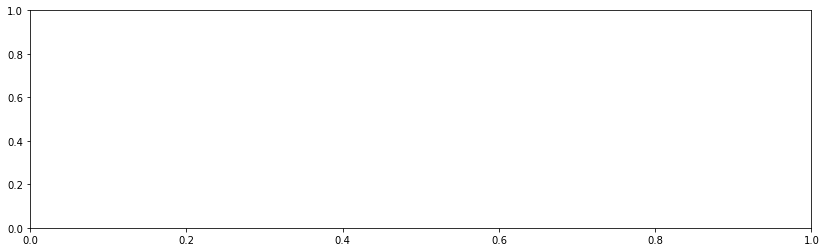

In [8]:
fig, ax = plt.subplots(figsize=(14,4))
wsbs_bar.plot(ax=ax, c='r', lw=3)
gradbb2H_bar.plot(ax=ax, c='k', ls='--', lw=2)

In [ ]:
gradbb2H.name = 'BFK'
wsbsb_ML.name = 'wsbs'
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(20,5))
# fig.set_tight_layout(True)
gs = GridSpec(1,5,figure=fig)
ax1 = fig.add_subplot(gs[0,:2])
ax2 = fig.add_subplot(gs[0,2:4])
ax3 = fig.add_subplot(gs[0,4])
wsbsb_ML[0,14,1:-1,1:-1].plot(ax=ax1, vmax=5e-8, cmap='coolwarm', rasterized=True)
(1e2*gradbb2H[15,0]).plot(ax=ax2, vmin=0., vmax=5e-8, cmap='Reds', rasterized=True)
xhist(1e2*gradbb2H[1:].transpose('time_counter','deptht','y','x').chunk({'time_counter':1}), 
      wsbsb_ML[:,:,1:-1,1:-1].chunk({'time_counter':1}),
      bins=[np.logspace(-11,-6,30), np.logspace(-11,-6,30)]).plot(ax=ax3, cmap='Blues')
ax3.plot(np.linspace(1e-11,1e-6), np.linspace(1e-11,1e-6), c='grey', ls='--')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_ylim([1e-11,1e-6])
ax3.set_xlim([1e-11,1e-6])
ax3.set_xlabel(r"$\overline{w'b'}^{xy}$ [m$^2$ s$^{-3}$]", fontsize=14)
ax3.set_ylabel(r"$\frac{H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2}{f}$ [m$^2$ s$^{-3}$]", 
               fontsize=14)
ax1.set_title(r"$\overline{w'b'}^{xy}$ [m$^2$ s$^{-3}$]", fontsize=15)
ax2.set_title(r"$H_{\tt ML}^2|\nabla_{\tt H}\overline{b}^{xyz}|^2 / f$ [m$^2$ s$^{-3}$]", 
             fontsize=15)
fig.suptitle(r"Nov. 2, 2009", fontsize=17, y=1.02)
# plt.savefig('/scratch/cnt0024/hmg2840/tuchida/Figs/Nov-2-2009_GulfStreamPatch.pdf')